<a href="https://colab.research.google.com/github/hrtnisri2016/vix-ds-hci/blob/main/Home_Credit_Default_Risk_(Data_Preparation_and_Modelling).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Import Libraries**

In [1]:
import os
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from matplotlib.patches import Patch
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif

### **Get Data**

In [2]:
folder_path = '/content/drive/MyDrive/home-credit-default-risk'

file_dict = {}  # Dictionary to store file paths

# List all files in the folder
for root, dirs, files in os.walk(folder_path):
    for file in files:
        file_path = os.path.join(root, file)
        file_name = os.path.splitext(file)[0]  # Get the file name without extension
        file_dict[file_name] = file_path

In [3]:
# application_train
path_application_train = file_dict['application_train_clean']
df_application_train = pd.read_csv(path_application_train)
print(f'\u2022 application_train\n  shape: {df_application_train.shape}')

# application_test
path_application_test = file_dict['application_test_clean']
df_application_test = pd.read_csv(path_application_test)
print(f'\u2022 application_test\n  shape: {df_application_test.shape}')

• application_train
  shape: (304524, 74)
• application_test
  shape: (48744, 73)


### **Regrouping Categorical Columns**

First, I will regroup certain categorical columns from `df_application_train` to consolidate their categories and improve their interpretability.

In [4]:
# Re-group NAME_TYPE_SUITE
df_application_train['NAME_TYPE_SUITE'] = df_application_train['NAME_TYPE_SUITE'].replace({
    'Children': 'Family',
    'Family': 'Family',
    'Spouse, partner': 'Family',
    'Other_A': 'Other',
    'Other_B': 'Other',
    'Group of people': 'Other'
})

In [5]:
# Re-group NAME_FAMILY_STATUS
df_application_train['NAME_FAMILY_STATUS'] = df_application_train['NAME_FAMILY_STATUS'].replace({
    'Civil marriage': 'Married',
    'Married': 'Married',
    'Separated': 'Separated',
    'Widow': 'Separated',
    'Single / not married': 'Single'
})

In [6]:
# Re-group NAME_HOUSING_TYPE
df_application_train['NAME_HOUSING_TYPE'] = df_application_train['NAME_HOUSING_TYPE'].replace({
    'Rented apartment': 'Rented or Other Apartments',
    'Municipal apartment': 'Rented or Other Apartments',
    'Office apartment': 'Rented or Other Apartments',
    'Co-op apartment': 'Rented or Other Apartments'
})

In [7]:
# Re-group OCCUPATION_TYPE
df_application_train['OCCUPATION_TYPE'] = df_application_train['OCCUPATION_TYPE'].replace({
    'Laborers': 'Laborers',
    'Core staff': 'Professional',
    'Accountants': 'Professional',
    'Managers': 'Professional',
    'Drivers': 'Support Staff',
    'Sales staff': 'Support Staff',
    'Cleaning staff': 'Service Staff',
    'Cooking staff': 'Service Staff',
    'Private service staff': 'Service Staff',
    'Medicine staff': 'Service Staff',
    'Security staff': 'Service Staff',
    'High skill tech staff': 'Professional',
    'Waiters/barmen staff': 'Support Staff',
    'Low-skill Laborers': 'Laborers',
    'Realty agents': 'Professional',
    'Secretaries': 'Support Staff',
    'IT staff': 'Administrative',
    'HR staff': 'Administrative',
    'None': 'Other'
})

In [8]:
# Define the regex patterns for grouping
patterns = {
    r'Business Entity Type [1-3]': 'Business Entity',
    r'School|Kindergarten|University': 'Education',
    r'Government|Security Ministries|Police|Military': 'Government/Security',
    r'Electricity': 'Utilities',
    r'Medicine': 'Healthcare',
    r'Construction|Housing': 'Construction/Real Estate',
    r'Trade: type [1-7]': 'Trade',
    r'Industry: type [1-9]|Industry: type 1[01]|Industry: type 12|Industry: type 13': 'Industry',
    r'Transport: type [1-4]': 'Transport',
    r'Emergency': 'Emergency Services',
    r'Services': 'Services',
    r'Mobile|Telecom': 'Telecommunications',
    r'Bank|Insurance': 'Financial Services',
    r'Postal': 'Postal Services',
    r'Culture|Hotel|Restaurant|Cleaning|Advertising|Legal Services|Realtor': 'Services',
    r'None': 'Other'
}

# Function to perform regex grouping
def regex_grouping(value):
    for pattern, category in patterns.items():
        if re.search(pattern, value):
            return category
    return value

# Apply the regex grouping to the 'ORGANIZATION_TYPE' column
df_application_train['ORGANIZATION_TYPE'] = df_application_train['ORGANIZATION_TYPE'].apply(regex_grouping)

### **Visualizing Proportion of TARGET by Categorical Columns**

To understand the relationship between categorical columns and the target variable, we can plot the proportion of TARGET 1 and TARGET 0 for each category of the column. The function `plot_proportion_target_by` calculates the proportions and creates a 100% stacked bar plot to visualize the results.

In [9]:
def plot_proportion_target_by(column_name, figsize=(12, 3)):
    """
    Plot the proportion of TARGET 1 and TARGET 0 for each category of a given column.

    Args:
        column_name (str): Name of the column.
        figsize (tuple, optional): Figure size. Defaults to (12, 3).
    """
    # Calculate the proportion of TARGET 1 for each category of column_name
    proportion_target1 = df_application_train.groupby(column_name)['TARGET'].mean()

    # Calculate the proportion of TARGET 0 for each category of column_name
    proportion_target0 = 1 - proportion_target1

    # Create a 100% stacked bar plot
    plt.figure(figsize=figsize)
    sns.barplot(x=proportion_target1.index, y=proportion_target1.values, 
                color="#D32F2F")
    sns.barplot(x=proportion_target1.index, y=proportion_target0.values, 
                color="#000080", bottom=proportion_target1.values)

    # Add proportion labels inside the plot
    for i in range(len(proportion_target1)):
        plt.text(i, proportion_target1.values[i] / 2, f'{proportion_target1.values[i]:.2f}', 
                 ha='center', va='center', color='white', fontweight='bold')
        plt.text(i, proportion_target1.values[i] + proportion_target0.values[i] / 2, 
                 f'{proportion_target0.values[i]:.2f}', 
                 ha='center', va='center', color='white', fontweight='bold')

    # Create custom legend patches
    legend_patches = [
        Patch(facecolor='#D32F2F', label='TARGET 1'),
        Patch(facecolor='#000080', label='TARGET 0')
    ]

    plt.title(f'Proportion of TARGET by {column_name}')
    plt.xlabel(f'{column_name}')
    plt.ylabel('Proportion')
    plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left')

We iterate over the categorical columns in the dataset and call `plot_proportion_target_by` for each column. For columns `NAME_INCOME_TYPE` and `ORGANIZATION_TYPE`, we rotate the x-labels for better readability.

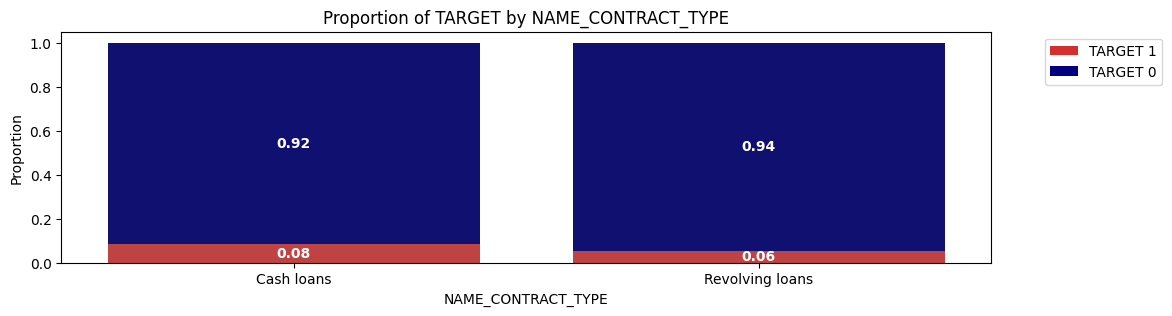

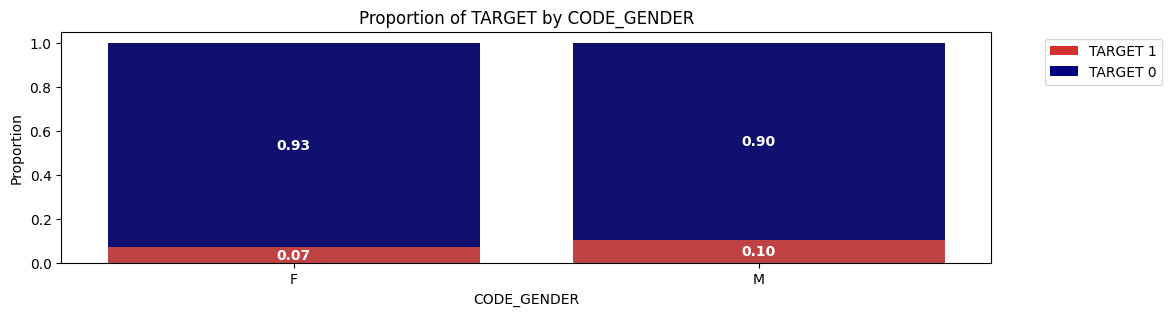

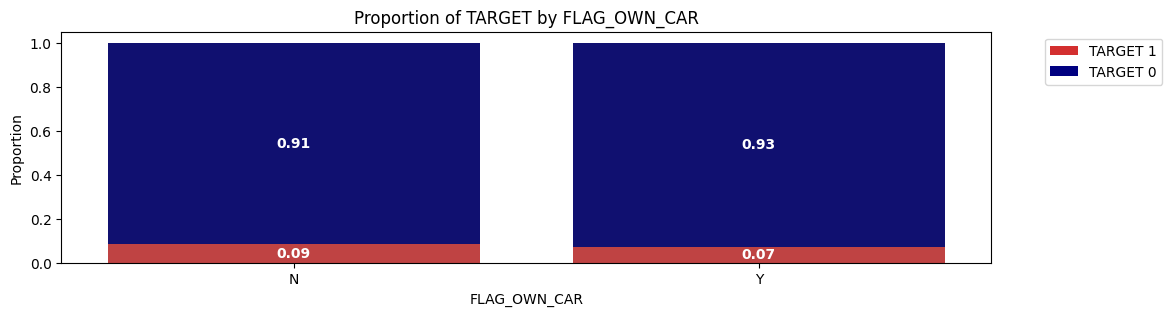

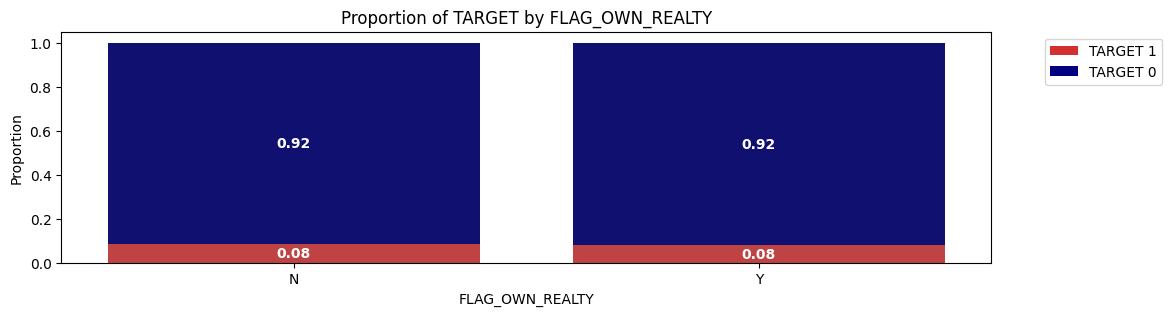

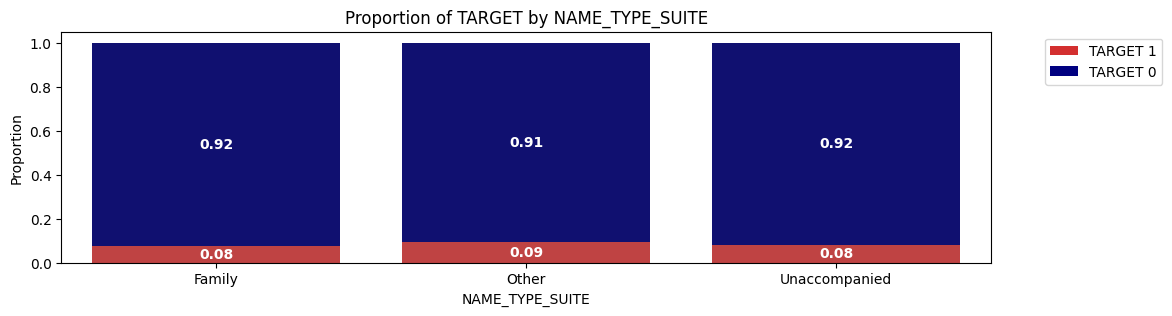

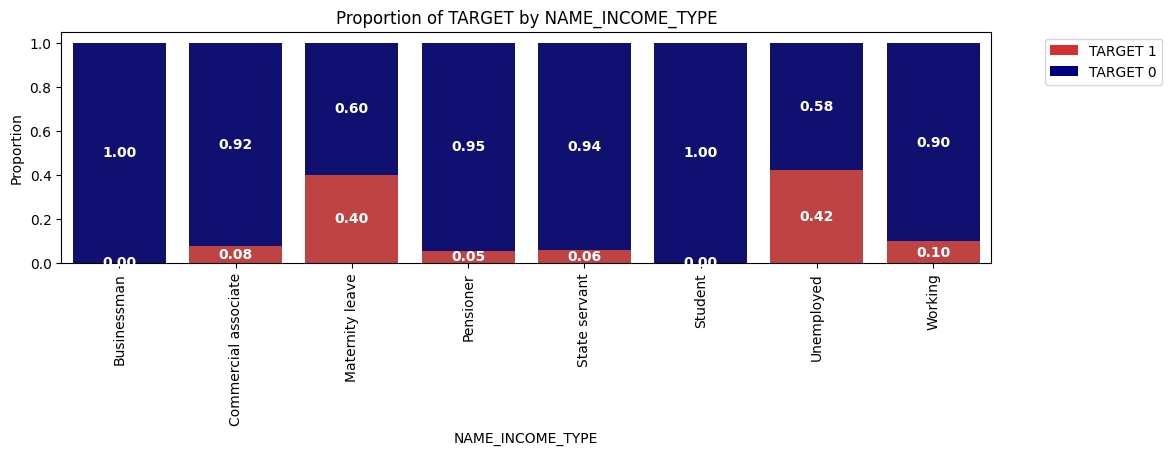

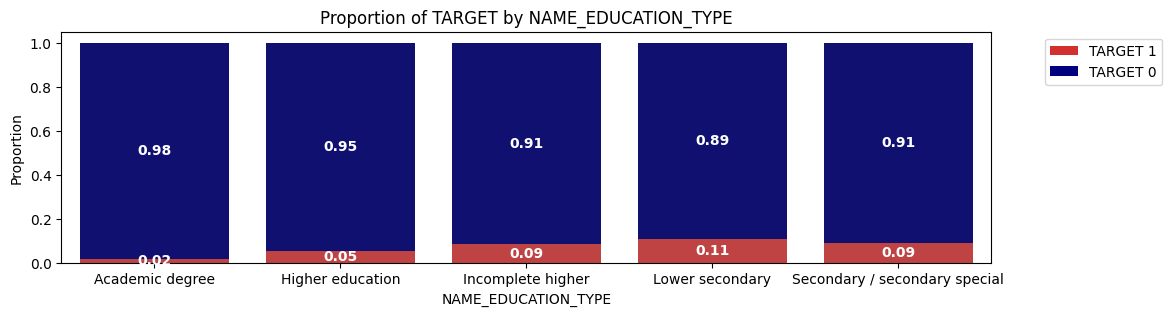

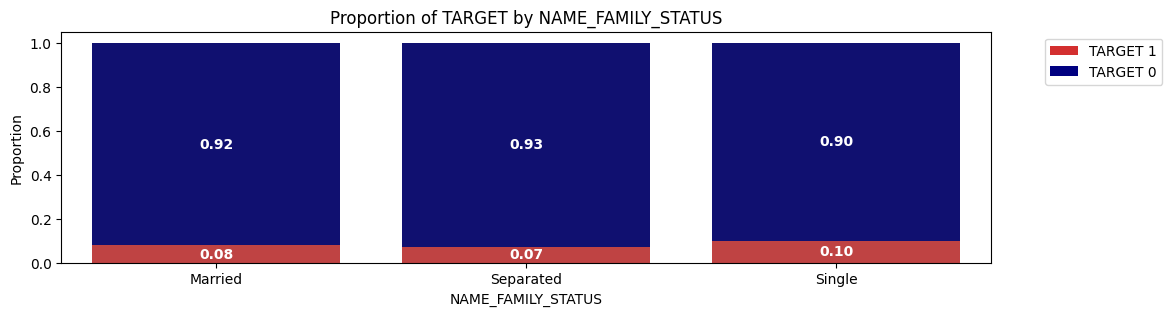

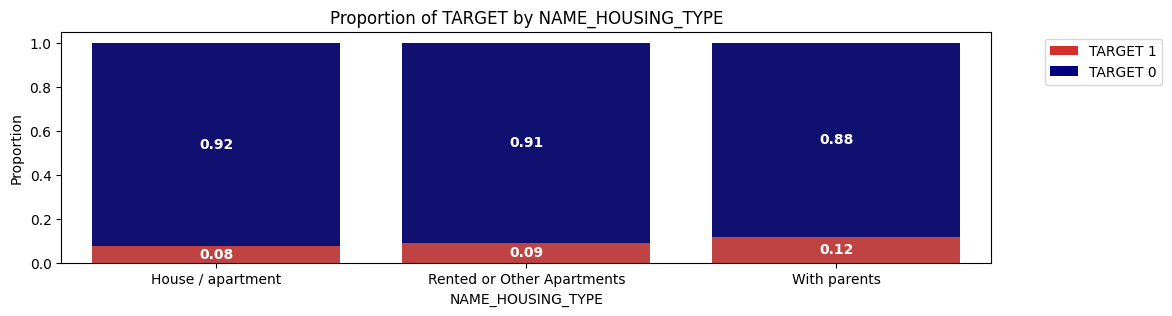

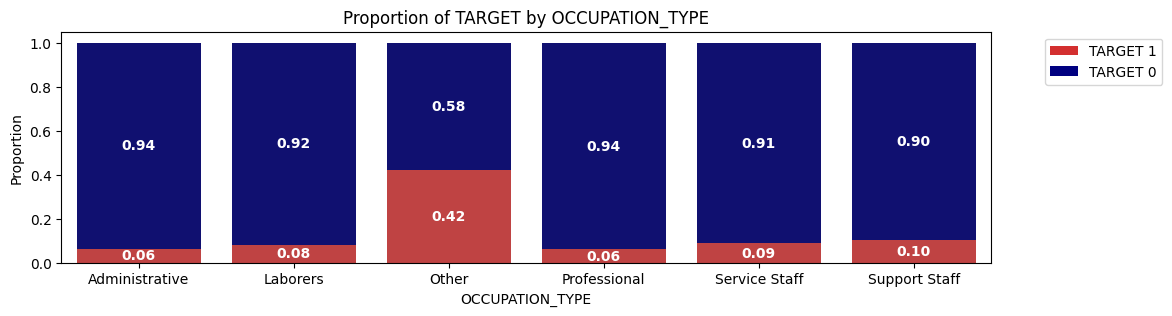

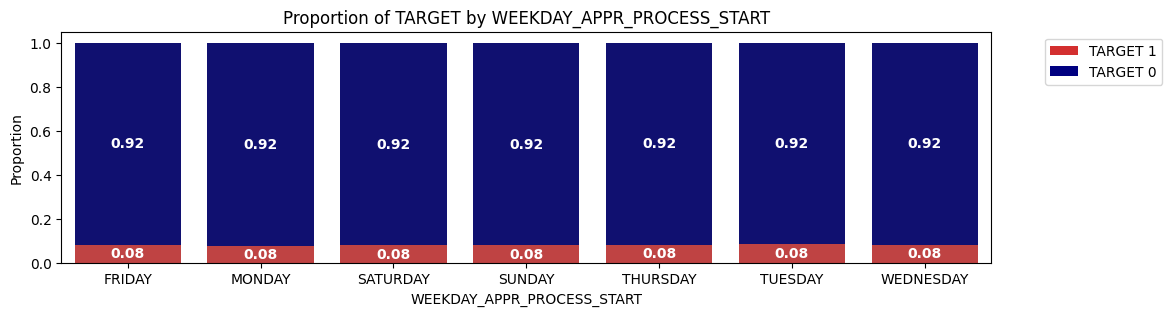

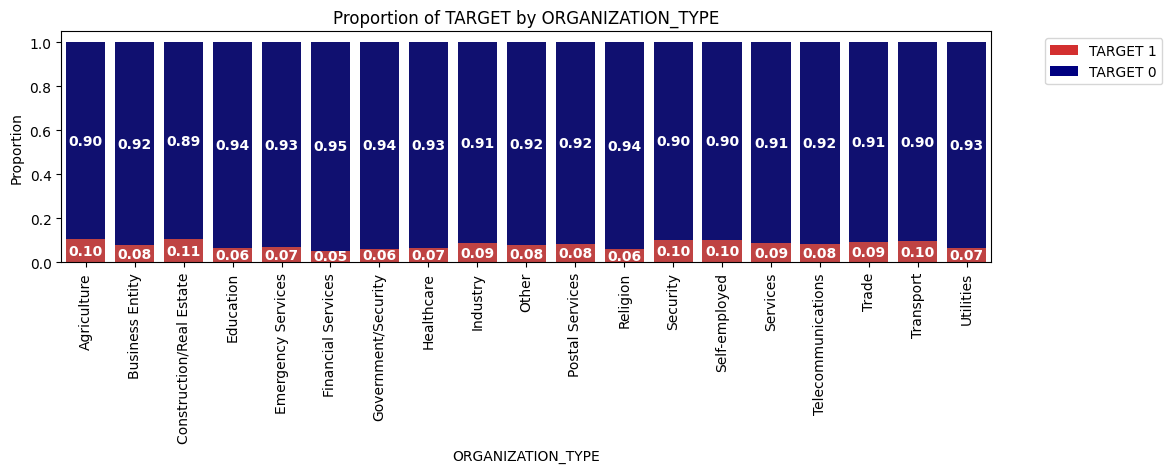

In [10]:
categorical_features = df_application_train.select_dtypes(include='object')
for col in categorical_features.columns:
    plot_proportion_target_by(col)
    if col == 'NAME_INCOME_TYPE' or col == 'ORGANIZATION_TYPE':
        # Set x-label rotation
        plt.xticks(rotation=90)
    plt.show()

From these plots, we can observe some interesting patterns in the relationship between the target variable and the categorical columns. 

First, it is evident that almost half (actually 0.4) of the individuals with `Maternity leave` as their `NAME_INCOME_TYPE`are facing difficulties in paying back the loan. Similarly, the same trend is observed for `Unemployed` individuals. 

Interestingly, while it might not come as a surprise that businessmen have a relatively low proportion of loan payment difficulties, it is worth noting that students also exhibit no difficulties in loan payment. However, it's important to consider that students account for only 0.005% of the dataset, and businessmen represent only 0.003% of the dataset. On the other hand, a significant portion of the dataset consists of working individuals.

In [11]:
# Calculate the percentage distribution of each category in the 'NAME_INCOME_TYPE' 
df_application_train['NAME_INCOME_TYPE'].value_counts() / len(df_application_train) * 100

Working                 51.665879
Commercial associate    23.247100
Pensioner               18.008761
State servant            7.061512
Unemployed               0.006239
Student                  0.005582
Businessman              0.003284
Maternity leave          0.001642
Name: NAME_INCOME_TYPE, dtype: float64

Taking these observations into account, it is reasonable to expect that the `NAME_INCOME_TYPE` and `OCCUPATION_TYPE` columns could be important features in predicting loan repayment difficulties.

### **Encoding Categorical Features and Dropping Object Columns**

Binary features such as `NAME_CONTRACT_TYPE`, `CODE_GENDER`, `FLAG_OWN_CAR`, and `FLAG_OWN_REALTY` are encoded using `LabelEncoder`, while the specified categorical features are one-hot encoded using `pd.get_dummies()`. The resulting encoded features are then concatenated back to the original dataframe, and the object columns are dropped to obtain the final encoded dataframe stored in `df_application_train_encoded`.

In [12]:
# Encode features using appropriate methods
binary_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder(sparse=False)

df_application_train['NAME_CONTRACT_TYPE_Revolving_loans'] = binary_encoder.fit_transform(df_application_train['NAME_CONTRACT_TYPE'])
df_application_train['CODE_GENDER_Male'] = binary_encoder.fit_transform(df_application_train['CODE_GENDER'])
df_application_train['FLAG_OWN_CAR'] = binary_encoder.fit_transform(df_application_train['FLAG_OWN_CAR'])
df_application_train['FLAG_OWN_REALTY'] = binary_encoder.fit_transform(df_application_train['FLAG_OWN_REALTY'])

# Perform one-hot encoding
categorical_features = [
    'NAME_TYPE_SUITE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
    'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE',
    'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE']

encoded_features = pd.get_dummies(df_application_train[categorical_features])

# Concatenate the encoded features back to the original dataframe
df_application_train_encoded = pd.concat([df_application_train, encoded_features], axis=1)

# Identify object columns
object_columns = df_application_train_encoded.select_dtypes(include=['object']).columns

# Drop the object columns
df_application_train_encoded = df_application_train_encoded.drop(object_columns, axis=1)

### **Dropping Redundant Features**

In [13]:
# Check for columns with only one unique value
for column in df_application_train_encoded.columns:
    unique_values = df_application_train_encoded[column].nunique()
    if unique_values == 1:
        print(f"Column '{column}' consists of only one unique value.")

Column 'FLAG_MOBIL' consists of only one unique value.


In [14]:
def check_strong_corr(df, threshold=0.8):
    # Identify any strong correlations among features
    correlation_matrix = df.corr()

    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            if abs(correlation_matrix.iloc[i, j]) > threshold:
                # Print the pair of features and their correlation
                feature_1 = correlation_matrix.columns[i]
                feature_2 = correlation_matrix.columns[j]
                correlation = correlation_matrix.iloc[i, j]
                print(f"\u2022 Features: {feature_1} and {feature_2}")
                print(f"  Correlation: {round(correlation, 2)}")

In [15]:
check_strong_corr(df_application_train_encoded, threshold=0.8)

• Features: CNT_CHILDREN and CNT_FAM_MEMBERS
  Correlation: 0.88
• Features: AMT_CREDIT and AMT_GOODS_PRICE
  Correlation: 0.99
• Features: FLAG_EMP_PHONE and NAME_INCOME_TYPE_Pensioner
  Correlation: -1.0
• Features: REGION_RATING_CLIENT and REGION_RATING_CLIENT_W_CITY
  Correlation: 0.95
• Features: REG_REGION_NOT_WORK_REGION and LIVE_REGION_NOT_WORK_REGION
  Correlation: 0.86
• Features: REG_CITY_NOT_WORK_CITY and LIVE_CITY_NOT_WORK_CITY
  Correlation: 0.83
• Features: OBS_30_CNT_SOCIAL_CIRCLE and OBS_60_CNT_SOCIAL_CIRCLE
  Correlation: 1.0
• Features: DEF_30_CNT_SOCIAL_CIRCLE and DEF_60_CNT_SOCIAL_CIRCLE
  Correlation: 0.86
• Features: EXT_SOURCE_MEAN and EXT_SOURCE_MEDIAN
  Correlation: 0.97
• Features: NAME_TYPE_SUITE_Family and NAME_TYPE_SUITE_Unaccompanied
  Correlation: -0.97
• Features: NAME_INCOME_TYPE_Unemployed and OCCUPATION_TYPE_Other
  Correlation: 1.0
• Features: NAME_EDUCATION_TYPE_Higher education and NAME_EDUCATION_TYPE_Secondary / secondary special
  Correlation: -

Upon analyzing the correlation matrix, we have identified pairs of features that exhibit very high correlation with each other. To avoid multicollinearity, which can cause issues in certain statistical models, we will need to drop one feature from each correlated pair. Additionally, since the `FLAG_MOBIL` feature consists of only one unique value, it does not provide any meaningful information and will be removed from the dataset.

In [16]:
columns_to_drop = [
    'FLAG_MOBIL', 'CNT_FAM_MEMBERS', 'AMT_GOODS_PRICE', 'NAME_INCOME_TYPE_Pensioner', 
    'REGION_RATING_CLIENT_W_CITY', 'LIVE_REGION_NOT_WORK_REGION', 'LIVE_CITY_NOT_WORK_CITY', 
    'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'EXT_SOURCE_MEDIAN', 
    'NAME_TYPE_SUITE_Unaccompanied', 'OCCUPATION_TYPE_Other', 
    'NAME_EDUCATION_TYPE_Secondary / secondary special'
]

df_application_train_encoded.drop(columns_to_drop, axis=1, inplace=True)

### **Removing Outliers**

Removing rows with outliers in selected features.

    [PART 1] 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE', 'OWN_CAR_AGE'

    [PART 2] 'CNT_CHILDREN'

    [PART 3] 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK', 
             'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR'

    [PART 4] 'HOUR_APPR_PROCESS_START'

    [PART 5] 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE'

    [PART 6] 'REGION_POPULATION_RELATIVE', 'EXT_SOURCE_MEAN'
    
    [PART 7] 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY'

In [17]:
def plot_boxplot(columns, figsize=(8, 3)):
    plt.figure(figsize=figsize)
    sns.boxplot(data=df_application_train_encoded[columns], orient='h')
    plt.yticks(range(0, len(columns)), columns)

##### **PART 1**

In [18]:
days_columns = ['DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE']
df_application_train_encoded[days_columns] = df_application_train_encoded[days_columns].apply(abs)

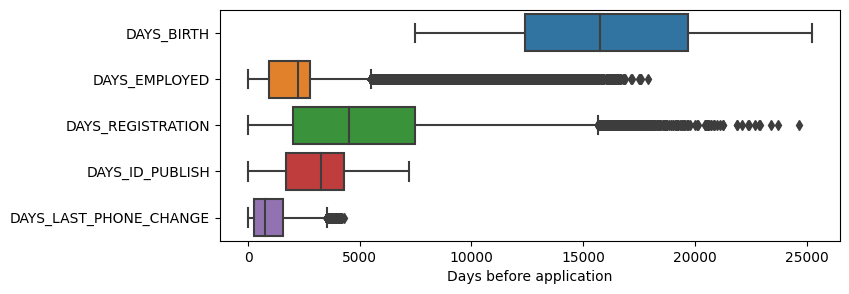

In [19]:
plot_boxplot(days_columns)
plt.xlabel('Days before application')
plt.show()

It's not easy to interpret time in days, is it? It doesn't feel intuitive, so I decided to convert it into years.

In [20]:
# Converting days to years
df_application_train_encoded['AGE'] = df_application_train_encoded['DAYS_BIRTH'] / 365
df_application_train_encoded['YEARS_EMPLOYED'] = df_application_train_encoded['DAYS_EMPLOYED'] / 365
df_application_train_encoded['YEARS_REGISTRATION'] = df_application_train_encoded['DAYS_REGISTRATION'] / 365
df_application_train_encoded['YEARS_ID_PUBLISH'] = df_application_train_encoded['DAYS_ID_PUBLISH'] / 365
df_application_train_encoded['YEARS_LAST_PHONE_CHANGE'] = df_application_train_encoded['DAYS_LAST_PHONE_CHANGE'] / 365

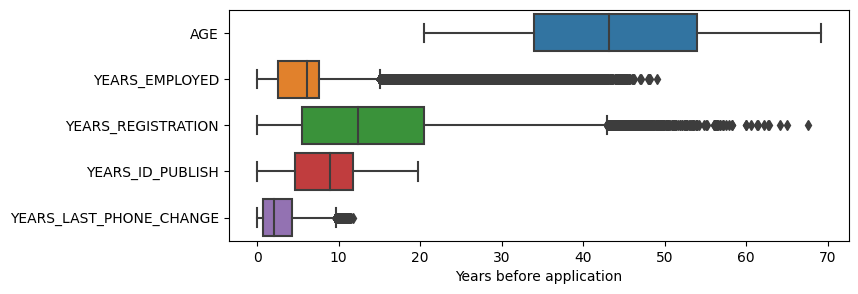

In [21]:
plot_boxplot(['AGE', 'YEARS_EMPLOYED', 'YEARS_REGISTRATION', 'YEARS_ID_PUBLISH', 'YEARS_LAST_PHONE_CHANGE'])
plt.xlabel('Years before application')
plt.show()

Doesn't this plot make you wonder what age this client could possibly be, given that they changed their registration approximately 68 years before the application?

This must have been skipped during data validation, so let's fix the data now by creating new columns to see the age when a client started their current employment, changed their registration, changed their identity document, and changed their phone.

In [22]:
# Calculate the age at which a client started current employment
df_application_train_encoded['AGE_EMPLOYED'] = df_application_train_encoded['AGE'] - df_application_train_encoded['YEARS_EMPLOYED']
# Calculate the age at which a client changed their registration
df_application_train_encoded['AGE_REGISTRATION'] = df_application_train_encoded['AGE'] - df_application_train_encoded['YEARS_REGISTRATION']
# Calculate the age at which a client changed their identity document
df_application_train_encoded['AGE_ID_PUBLISH'] = df_application_train_encoded['AGE'] - df_application_train_encoded['YEARS_ID_PUBLISH']
# Calculate the age at which a client changed their phone
df_application_train_encoded['AGE_LAST_PHONE_CHANGE'] = df_application_train_encoded['AGE'] - df_application_train_encoded['YEARS_LAST_PHONE_CHANGE']

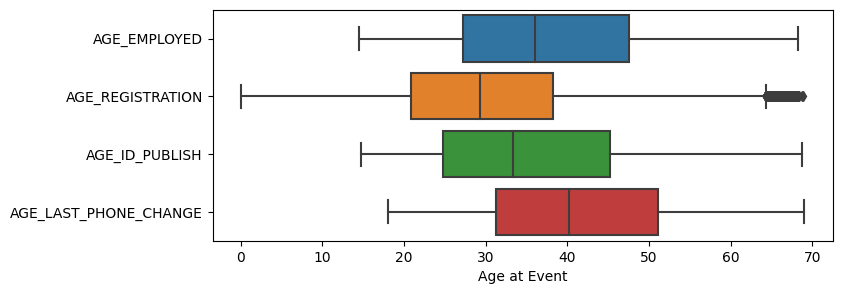

In [23]:
plot_boxplot(['AGE_EMPLOYED', 'AGE_REGISTRATION', 'AGE_ID_PUBLISH', 'AGE_LAST_PHONE_CHANGE'])
plt.xlabel('Age at Event')
plt.show()

I'm uncertain about how to handle observations where the age at which individuals changed their registration appears to be unrealistic. Determining the appropriate age threshold for valid registration changes is challenging as it may depend on their age at the time of registration. However, upon examining the dataset, I noticed that the youngest client, approximately 20 years old, had changed their registration at the age of 14. Therefore, I will use 14 as the threshold and remove any observations where the `AGE_REGISTRATION` is less than 14.

In [24]:
# Find the minimum value in the 'AGE' column
min_age = min(df_application_train_encoded['AGE'])

# Select rows where 'AGE' column has the minimum value and extract specified columns
df_application_train_encoded[df_application_train_encoded['AGE'] < 21][[
    'CODE_GENDER_Male', 'AGE', 'AGE_EMPLOYED', 'AGE_REGISTRATION', 'AGE_ID_PUBLISH', 'AGE_LAST_PHONE_CHANGE'
]]

,CODE_GENDER_Male,AGE,AGE_EMPLOYED,AGE_REGISTRATION,AGE_ID_PUBLISH,AGE_LAST_PHONE_CHANGE
233161,0,20.517808,18.334247,14.167123,20.093151,18.810959


In [25]:
# filter based on AGE_REGISTRATION
df_application_train_encoded = df_application_train_encoded[df_application_train_encoded['AGE_REGISTRATION'] >= 14]

Since we have discussed features that are measured in years, let's proceed by creating a boxplot for the `OWN_CAR_AGE` column.

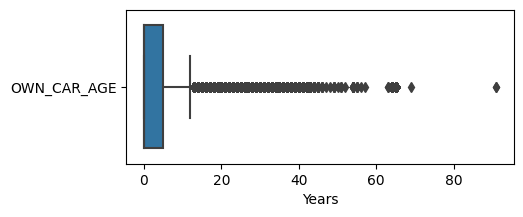

In [26]:
plot_boxplot(['OWN_CAR_AGE'], figsize=(5,2))
plt.xlabel('Years')
plt.show()

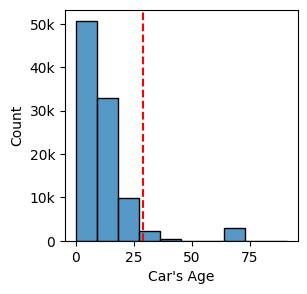

In [27]:
# Calculate the 95th percentile
data = df_application_train_encoded[df_application_train_encoded['FLAG_OWN_CAR']==1]
percentile_95 = data['OWN_CAR_AGE'].quantile(0.95)

plt.figure(figsize=(3, 3))
sns.histplot(data=data, x='OWN_CAR_AGE', bins=10)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x / 1000)}k' if x > 0 else '0'))
plt.xlabel("Car's Age")
plt.ylabel('Count')
plt.axvline(x=percentile_95, color='red', linestyle='--') # Add a border for the 95th percentile
plt.show()

Here, I have decided to keep only the observations where the car's age values are within the 95th percentile. Upon further investigation, it turns out that there are no car ages that exceed the client's age.

In [28]:
# Filter the DataFrame to include only rows with 'OWN_CAR_AGE' values within the 95th percentile
df_application_train_encoded = df_application_train_encoded[df_application_train_encoded['OWN_CAR_AGE'] <= percentile_95]

##### **PART 2**

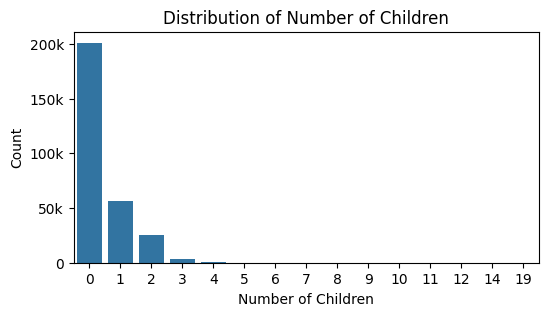

In [29]:
plt.figure(figsize=(6, 3))
sns.countplot(data=df_application_train_encoded, x='CNT_CHILDREN', color=sns.color_palette()[0])
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x / 1000)}k' if x > 0 else '0'))
plt.xlabel('Number of Children')
plt.ylabel('Count')
plt.title('Distribution of Number of Children')
plt.show()

Upon analyzing the data, it is interesting to note that there are individuals who are as young as 28 or 30 years old but already have 19 children. To further investigate this anomaly, I have created a new column called `MAX_FIRST_CHILD_AGE.` This column represents the maximum age at which a person could have their first child, assuming a two-year interval between each child and no occurrence of multiple births (e.g., twins). 

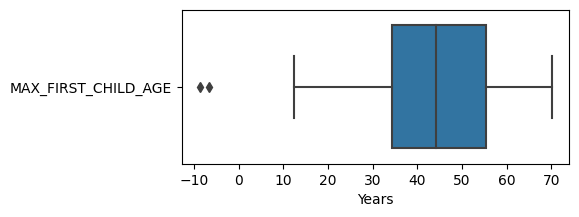

In [30]:
df_application_train_encoded['MAX_FIRST_CHILD_AGE'] = df_application_train_encoded['AGE'] + 1 - 2 * df_application_train_encoded['CNT_CHILDREN']
plot_boxplot(['MAX_FIRST_CHILD_AGE'], figsize=(5,2))
plt.xlabel('Years')
plt.show()

In [31]:
df_application_train_encoded[df_application_train_encoded['MAX_FIRST_CHILD_AGE'] < 10][[
    'AGE', 'CNT_CHILDREN', 'MAX_FIRST_CHILD_AGE'
]]

,AGE,CNT_CHILDREN,MAX_FIRST_CHILD_AGE
153869,30.293151,19,-6.706849
263216,28.210959,19,-8.789041


Those two individuals who have 19 children are considered outliers, and we will remove them from the dataset.

In [32]:
# Remove the outlier
df_application_train_encoded = df_application_train_encoded[df_application_train_encoded['MAX_FIRST_CHILD_AGE'] > 10]
# Delete the MAX_FIRST_CHILD_AGE column
df_application_train_encoded.drop('MAX_FIRST_CHILD_AGE', axis=1, inplace=True)

<ipython-input-32-7355c6731737>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_application_train_encoded.drop('MAX_FIRST_CHILD_AGE', axis=1, inplace=True)


##### **PART 3**

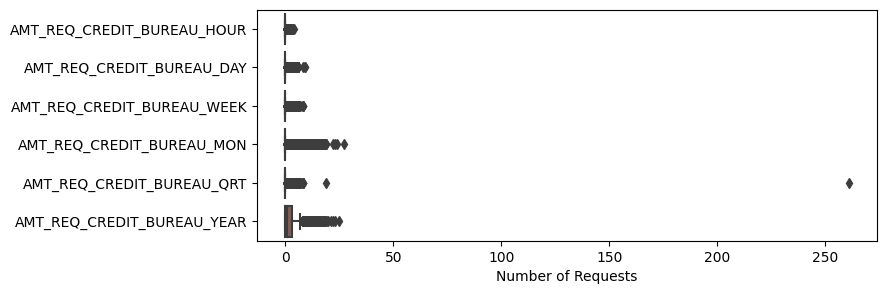

In [33]:
req_columns = ['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 
               'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']

plot_boxplot(req_columns)
plt.xlabel('Number of Requests')
plt.show()

In [34]:
df_application_train_encoded = df_application_train_encoded[
    df_application_train_encoded['AMT_REQ_CREDIT_BUREAU_QRT'] < 50]

##### **PART 4**

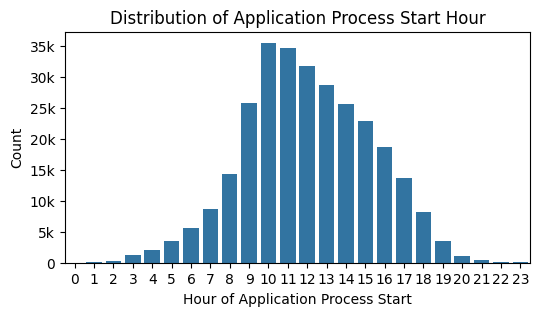

In [35]:
plt.figure(figsize=(6, 3))
sns.countplot(data=df_application_train_encoded, x='HOUR_APPR_PROCESS_START', color=sns.color_palette()[0])
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x / 1000)}k' if x > 0 else '0'))
plt.xlabel('Hour of Application Process Start')
plt.ylabel('Count')
plt.title('Distribution of Application Process Start Hour')
plt.show()

#### **PART 5**

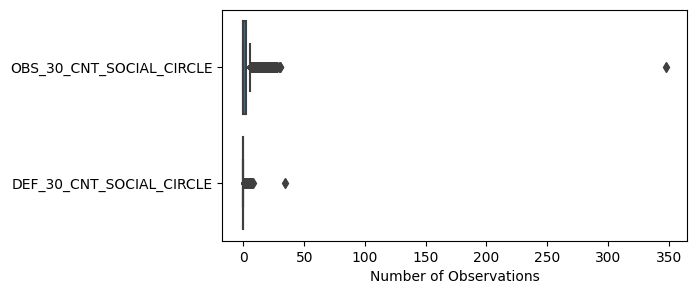

In [36]:
req_columns = ['OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE']
plot_boxplot(req_columns, figsize=(6,3))
plt.xlabel('Number of Observations')
plt.show()

In [37]:
df_application_train_encoded = df_application_train_encoded[
    df_application_train_encoded['OBS_30_CNT_SOCIAL_CIRCLE'] < 50
]

####**PART 6**

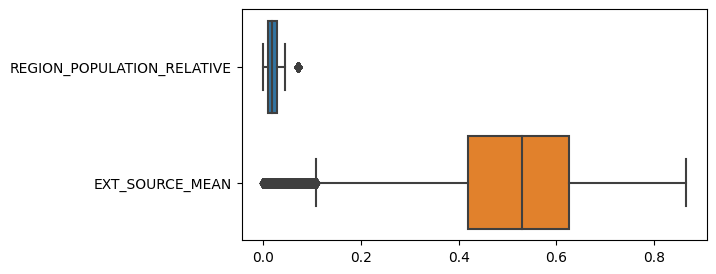

In [38]:
req_columns = ['REGION_POPULATION_RELATIVE', 'EXT_SOURCE_MEAN']
plot_boxplot(req_columns, figsize=(6,3))
plt.show()

#### **PART 7**

In [39]:
def remove_outliers_using_iqr(df, column_name):
    # Calculate the IQR
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Drop outliers from the dataframe
    df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

    return df

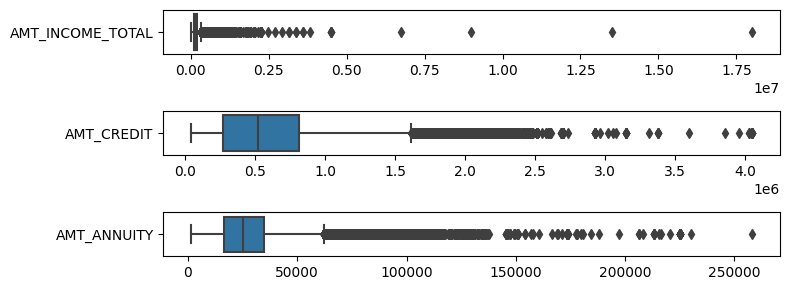

In [40]:
# Create a 3-row subplot figure
fig, axes = plt.subplots(3, 1, figsize=(8, 3))
columns = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY']

# Iterate over the columns and create boxplots
for i, column in enumerate(columns):
    ax = axes[i]
    sns.boxplot(data=df_application_train_encoded[column], orient='h', ax=ax)
    ax.set_yticklabels([column])
    ax.set_ylabel('')
    ax.set_xlabel('')

plt.tight_layout()
plt.show()

In [41]:
# Remove outliers
df_application_train_encoded = remove_outliers_using_iqr(df_application_train_encoded, 'AMT_INCOME_TOTAL')
df_application_train_encoded = remove_outliers_using_iqr(df_application_train_encoded, 'AMT_ANNUITY')
df_application_train_encoded = remove_outliers_using_iqr(df_application_train_encoded, 'AMT_CREDIT')

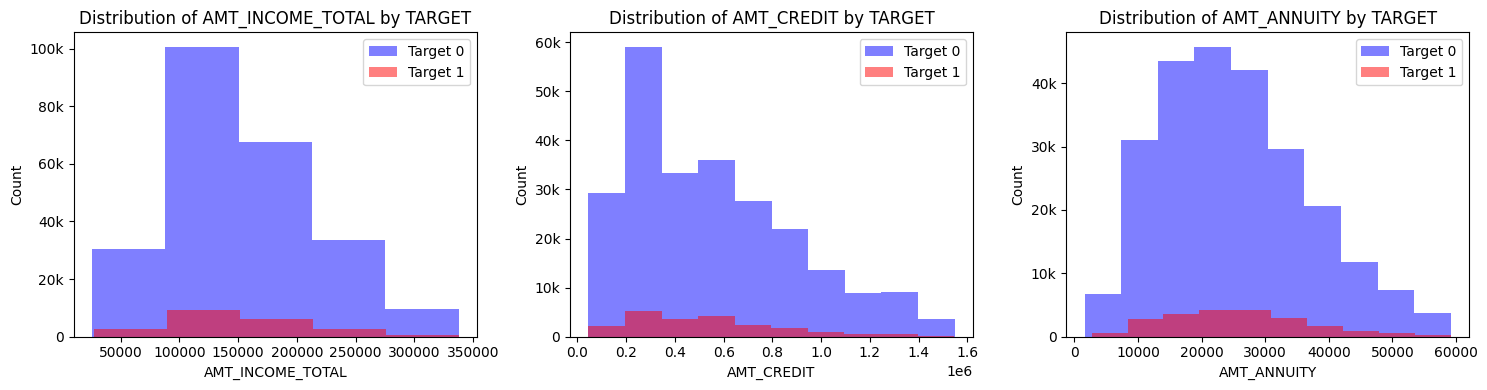

In [42]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

columns = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY']
bin_size = [5, 10, 10]

for i, col in enumerate(columns):
    ax = axes[i]
    ax.hist(df_application_train_encoded[df_application_train_encoded['TARGET'] == 0][col], 
            bins=bin_size[i], alpha=0.5, label='Target 0', color='blue')
    ax.hist(df_application_train_encoded[df_application_train_encoded['TARGET'] == 1][col], 
            bins=bin_size[i], alpha=0.5, label='Target 1', color='red')
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x / 1000)}k' if x > 0 else '0')) 
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
    ax.set_title(f'Distribution of {col} by TARGET')
    ax.legend()

plt.tight_layout()
plt.show()

### **Dropping Redundant Features II**

In [43]:
check_strong_corr(df_application_train_encoded, threshold=0.8)

• Features: DAYS_BIRTH and AGE
  Correlation: 1.0
• Features: DAYS_BIRTH and AGE_EMPLOYED
  Correlation: 0.88
• Features: DAYS_BIRTH and AGE_ID_PUBLISH
  Correlation: 0.94
• Features: DAYS_BIRTH and AGE_LAST_PHONE_CHANGE
  Correlation: 0.98
• Features: DAYS_EMPLOYED and YEARS_EMPLOYED
  Correlation: 1.0
• Features: DAYS_REGISTRATION and YEARS_REGISTRATION
  Correlation: 1.0
• Features: DAYS_ID_PUBLISH and YEARS_ID_PUBLISH
  Correlation: 1.0
• Features: DAYS_LAST_PHONE_CHANGE and YEARS_LAST_PHONE_CHANGE
  Correlation: 1.0
• Features: AGE and AGE_EMPLOYED
  Correlation: 0.88
• Features: AGE and AGE_ID_PUBLISH
  Correlation: 0.94
• Features: AGE and AGE_LAST_PHONE_CHANGE
  Correlation: 0.98
• Features: AGE_EMPLOYED and AGE_ID_PUBLISH
  Correlation: 0.82
• Features: AGE_EMPLOYED and AGE_LAST_PHONE_CHANGE
  Correlation: 0.87
• Features: AGE_ID_PUBLISH and AGE_LAST_PHONE_CHANGE
  Correlation: 0.92


In [44]:
columns_to_drop = [
    'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE',
    'AGE_EMPLOYED', 'AGE_ID_PUBLISH', 'AGE_LAST_PHONE_CHANGE']

df_application_train_encoded.drop(columns_to_drop, axis=1, inplace=True)

### **Normalization**

In [45]:
df_original = df_application_train_encoded.copy()

In [46]:
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Get all feature columns except the target column
feature_cols = df_application_train_encoded.columns.drop('TARGET')
print(feature_cols)

# Apply MinMaxScaler to the feature columns
df_application_train_encoded[feature_cols] = scaler.fit_transform(df_application_train_encoded[feature_cols])

Index(['SK_ID_CURR', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'REGION_POPULATION_RELATIVE', 'OWN_CAR_AGE', 'FLAG_EMP_PHONE',
       ...
       'ORGANIZATION_TYPE_Telecommunications', 'ORGANIZATION_TYPE_Trade',
       'ORGANIZATION_TYPE_Transport', 'ORGANIZATION_TYPE_Utilities', 'AGE',
       'YEARS_EMPLOYED', 'YEARS_REGISTRATION', 'YEARS_ID_PUBLISH',
       'YEARS_LAST_PHONE_CHANGE', 'AGE_REGISTRATION'],
      dtype='object', length=107)


### **Feature Selection**

In [47]:
# Separate the features (X) and the target variable (y)
X = df_application_train_encoded.drop(['TARGET', 'SK_ID_CURR'], axis=1)
y = df_application_train_encoded['TARGET']

# Initialize the SelectKBest object and specify the number of features to select
k = 20  # Specify the number of top features to select
selector = SelectKBest(score_func=f_classif, k=k)

# Fit the selector to the data and transform the features
X_new = selector.fit_transform(X, y)

# Get the selected feature indices and their corresponding scores
feature_indices = selector.get_support(indices=True)
feature_scores = selector.scores_[feature_indices]

# Get the names of the selected features
selected_features = X.columns[feature_indices].to_list()

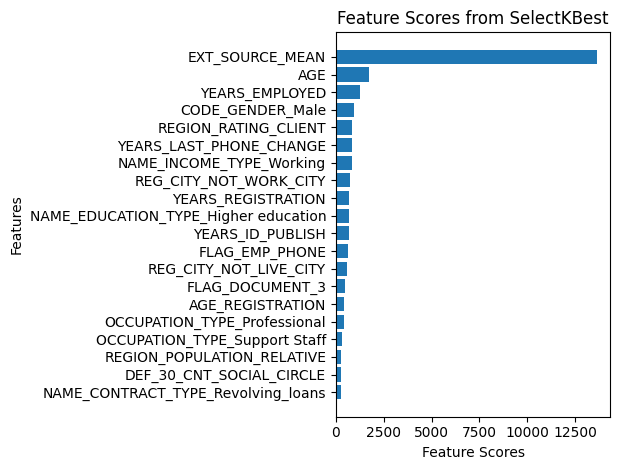

In [48]:
# Sort the feature scores and corresponding feature names
sorted_scores_indices = sorted(zip(feature_scores, selected_features), reverse=False)
sorted_scores = [score for score, _ in sorted_scores_indices]
sorted_features = [feature for _, feature in sorted_scores_indices]

# Create a horizontal bar plot to visualize the feature scores
plt.figure()
plt.barh(range(len(sorted_scores)), sorted_scores)
plt.yticks(range(len(sorted_scores)), sorted_features)
plt.ylabel('Features')
plt.xlabel('Feature Scores')
plt.title('Feature Scores from SelectKBest')
plt.tight_layout()
plt.show()

Train Accuracy: 0.9179
Validation Accuracy: 0.9179
Train ROC-AUC: 0.7235
Validation ROC-AUC: 0.7216
Confusion Matrix (Validation Data):
          Predicted 0  Predicted 1
Actual 0        48429            0
Actual 1         4329            0


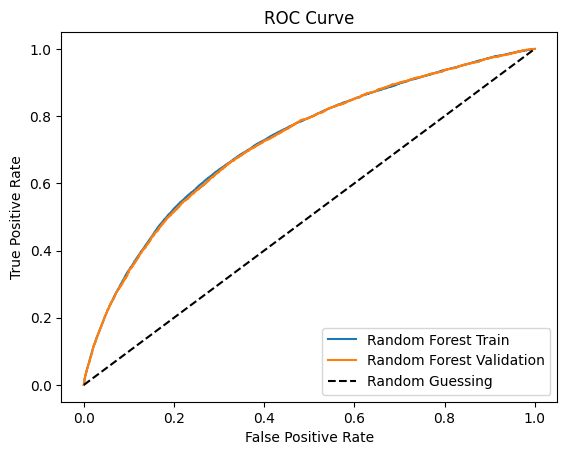

In [49]:
# Splitting the data into train and test sets
X = df_application_train_encoded.drop(['TARGET', 'SK_ID_CURR'], axis=1)
y = df_application_train_encoded['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initializing the Random Forest model
random_forest = RandomForestClassifier(max_depth=5)

# Training and evaluation on train-test split
random_forest.fit(X_train, y_train)
train_preds = random_forest.predict(X_train)
val_preds = random_forest.predict(X_test)
train_accuracy = accuracy_score(y_train, train_preds)
val_accuracy = accuracy_score(y_test, val_preds)
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# ROC-AUC score and visualization
train_prob = random_forest.predict_proba(X_train)[:, 1]
val_prob = random_forest.predict_proba(X_test)[:, 1]
train_roc_auc = roc_auc_score(y_train, train_prob)
val_roc_auc = roc_auc_score(y_test, val_prob)
print(f"Train ROC-AUC: {train_roc_auc:.4f}")
print(f"Validation ROC-AUC: {val_roc_auc:.4f}")

# Confusion matrix for validation data
confusion_mat = confusion_matrix(y_test, val_preds)

# Create a table with headers for rows and columns
confusion_df = pd.DataFrame(confusion_mat, 
               index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
print("Confusion Matrix (Validation Data):")
print(confusion_df)

# Plot ROC curve
fpr_train, tpr_train, _ = roc_curve(y_train, train_prob)
fpr_val, tpr_val, _ = roc_curve(y_test, val_prob)
plt.plot(fpr_train, tpr_train, label='Random Forest Train')
plt.plot(fpr_val, tpr_val, label='Random Forest Validation')

# Plot ROC curve for random guessing (baseline)
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

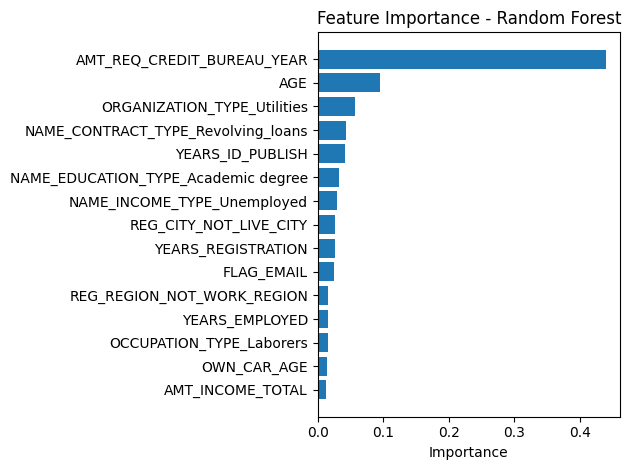

In [50]:
# Get feature importances from the trained Random Forest model
importances = random_forest.feature_importances_

# Get the feature names
feature_names = df_application_train_encoded.columns.drop('TARGET')

# Sort the feature importances in descending order
sorted_indices = importances.argsort()[::-1]
sorted_importances = importances[sorted_indices][:15]
sorted_feature_names = feature_names[sorted_indices][:15]

# Reverse the order of the importances and feature names
sorted_importances = sorted_importances[::-1]
sorted_feature_names = sorted_feature_names[::-1]

# Create a bar plot to visualize the feature importances
plt.figure()
plt.barh(range(len(sorted_importances)), sorted_importances, tick_label=sorted_feature_names)
plt.xlabel('Importance')
plt.title('Feature Importance - Random Forest')
plt.tight_layout()
plt.show()

In [51]:
feature_Kbest = set(selected_features)
feature_RF = set(sorted_feature_names[:15])
end_features = list(feature_Kbest.union(feature_RF))

In [52]:
df_final = df_application_train_encoded[['SK_ID_CURR', 'TARGET'] + end_features]

In [53]:
df_final['TARGET'].value_counts()

0    242139
1     21647
Name: TARGET, dtype: int64

## **Modeling**

In [54]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
import numpy as np

# Define the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(1, 11)
}

# Create the decision tree classifier
decision_tree = DecisionTreeClassifier()

# Create the RandomizedSearchCV object with scoring set to roc_auc
random_search = RandomizedSearchCV(estimator=decision_tree, param_distributions=param_grid,
                                   n_iter=10, cv=5, scoring='roc_auc', random_state=42)

# Fit the random search to the data
random_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding ROC AUC score
print("Best Hyperparameters:", random_search.best_params_)
print("Best ROC AUC Score:", random_search.best_score_)


Best Hyperparameters: {'max_depth': 6, 'criterion': 'gini'}
Best ROC AUC Score: 0.7197133144360853


Model: Decision Tree
Cross-Validation roc_auc: 0.7189
Train Accuracy: 0.9180
Validation Accuracy: 0.9179
Train ROC-AUC: 0.7303
Validation ROC-AUC: 0.7241
Confusion Matrix (Validation Data):
          Predicted 0  Predicted 1
Actual 0        48422            7
Actual 1         4324            5

Model: Logistic Regression
Cross-Validation roc_auc: 0.7329
Train Accuracy: 0.9178
Validation Accuracy: 0.9177
Train ROC-AUC: 0.7334
Validation ROC-AUC: 0.7348
Confusion Matrix (Validation Data):
          Predicted 0  Predicted 1
Actual 0        48389           40
Actual 1         4301           28



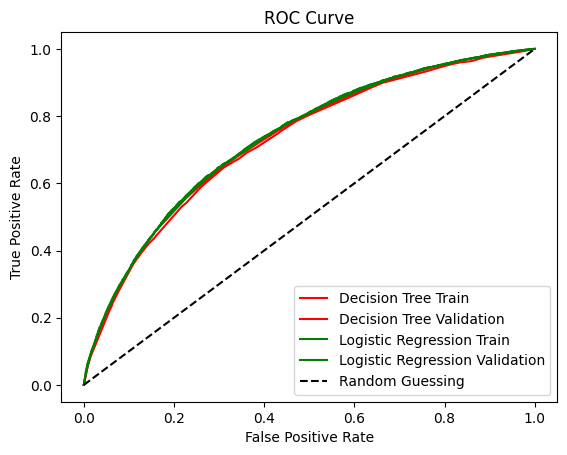

In [55]:
# Splitting the data into train and test sets
X = df_final.drop(['TARGET', 'SK_ID_CURR'], axis=1)
y = df_final['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initializing models
logistic_regression = LogisticRegression(penalty='l1', solver='liblinear')
decision_tree = DecisionTreeClassifier(max_depth=6, criterion='entropy')

# Creating a dictionary of models
models = {'Decision Tree': decision_tree,
          'Logistic Regression': logistic_regression}

# Define colors for the lines
line_colors = ['red', 'green']

# Perform 5-fold cross-validation and evaluate models
for i, (model_name, model) in enumerate(models.items()):
    print(f"Model: {model_name}")

    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_roc_auc_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')
    print(f"Cross-Validation roc_auc: {np.mean(cv_roc_auc_scores):.4f}")

    # Training and validation on train-test split
    model.fit(X_train, y_train)
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_test)
    train_accuracy = accuracy_score(y_train, train_preds)
    val_accuracy = accuracy_score(y_test, val_preds)
    print(f"Train Accuracy: {train_accuracy:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")

    # ROC-AUC score and visualization
    train_prob = model.predict_proba(X_train)[:, 1]
    val_prob = model.predict_proba(X_test)[:, 1]
    train_roc_auc = roc_auc_score(y_train, train_prob)
    val_roc_auc = roc_auc_score(y_test, val_prob)
    print(f"Train ROC-AUC: {train_roc_auc:.4f}")
    print(f"Validation ROC-AUC: {val_roc_auc:.4f}")

    # Confusion matrix for validation data
    confusion_mat = confusion_matrix(y_test, val_preds)

    # Create a table with headers for rows and columns
    confusion_df = pd.DataFrame(confusion_mat, 
                   index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
    print("Confusion Matrix (Validation Data):")
    print(confusion_df)

    print()

    # Plot ROC curve with custom line color
    fpr_train, tpr_train, _ = roc_curve(y_train, train_prob)
    fpr_val, tpr_val, _ = roc_curve(y_test, val_prob)
    plt.plot(fpr_train, tpr_train, label=f'{model_name} Train', color=line_colors[i])
    plt.plot(fpr_val, tpr_val, label=f'{model_name} Validation', color=line_colors[i])

# Plot ROC curve for random guessing (baseline)
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [56]:
import statsmodels.api as sm
# Fit logistic regression model using statsmodels
logit_model = sm.Logit(y_train, X_train)
logit_result = logit_model.fit()

# Print the statistical report
print(logit_result.summary())

Optimization terminated successfully.
         Current function value: 0.256212
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                 TARGET   No. Observations:               211028
Model:                          Logit   Df Residuals:                   210999
Method:                           MLE   Df Model:                           28
Date:                Sun, 04 Jun 2023   Pseudo R-squ.:                 0.09716
Time:                        03:53:36   Log-Likelihood:                -54068.
converged:                       True   LL-Null:                       -59886.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
YEARS_EMPLOYED                          -1.3171      0.0

## **Determining new threshold of good loans**

In [57]:
predictions = logistic_regression.predict_proba(X_test)
print(predictions)

[[0.84050986 0.15949014]
 [0.97534145 0.02465855]
 [0.91823973 0.08176027]
 ...
 [0.75431982 0.24568018]
 [0.97506038 0.02493962]
 [0.84769079 0.15230921]]


In [58]:
target = logistic_regression.predict(X_test)
print(target)

[0 0 0 ... 0 0 0]


In [59]:
# Create a DataFrame combining actual outcomes, predicted probabilities, and predicted targets
df_results = pd.DataFrame({
    'Actual_TARGET': y_test,
    'Probability_good_loan': predictions[:, 0],
    'Probability_bad_loan': predictions[:, 1],
    'Predicted_TARGET': target
})

# Add Decile column based on Probability_good_loan
df_results['Decile'] = 10 - pd.qcut(df_results['Probability_good_loan'], 10, labels=False, duplicates='drop')

# Sort the DataFrame by Probability_good_loan in descending order
df_results = df_results.sort_values('Probability_good_loan', ascending=False)

In [60]:
# Create a pivot table
pivot_table = df_results.pivot_table(
    index='Decile',
    aggfunc={
        'Decile': 'count',
        'Actual_TARGET': 'sum',
        'Probability_good_loan': 'min'
    },
    values=['Actual_TARGET', 'Probability_good_loan'],
    fill_value=0
)

# Rename the columns
pivot_table.columns = [
    'Bad Loans',
    'Observations',
    'Min Prob Good Loan'
]

pivot_table['Good Loans'] = pivot_table['Observations'] - pivot_table['Bad Loans']
pivot_table['CumSum Good Loans'] = pivot_table['Good Loans'].cumsum()
pivot_table['CumSum Bad Loans'] = pivot_table['Bad Loans'].cumsum()

total_good = sum(pivot_table['Good Loans'])
total_bad = sum(pivot_table['Bad Loans'])
pivot_table['CumSum Good Loans %'] = round(pivot_table['CumSum Good Loans'] / total_good, 2) * 100
pivot_table['CumSum Bad Loans %'] = round(pivot_table['CumSum Bad Loans'] / total_bad, 2) * 100
pivot_table['CumSum Bad Avoided %'] = 100 - pivot_table['CumSum Bad Loans %']

# Convert to integer
pivot_table['CumSum Good Loans %'] = pivot_table['CumSum Good Loans %'].astype(int)
pivot_table['CumSum Bad Loans %'] = pivot_table['CumSum Bad Loans %'].astype(int)
pivot_table['CumSum Bad Avoided %'] = pivot_table['CumSum Bad Avoided %'].astype(int)

pivot_table

,Bad Loans,Observations,Min Prob Good Loan,Good Loans,CumSum Good Loans,CumSum Bad Loans,CumSum Good Loans %,CumSum Bad Loans %,CumSum Bad Avoided %
Decile,,,,,,,,,
1,80,5276,0.977410,5196,5196,80,11,2,98
2,135,5276,0.969390,5141,10337,215,21,5,95
3,160,5276,0.961362,5116,15453,375,32,9,91
4,215,5275,0.952304,5060,20513,590,42,14,86
5,308,5276,0.941227,4968,25481,898,53,21,79
6,354,5276,0.927380,4922,30403,1252,63,28,71
7,395,5275,0.908625,4880,35283,1647,73,38,62
8,580,5276,0.880579,4696,39979,2227,83,51,49
9,793,5276,0.828044,4483,44462,3020,92,70,30


In [61]:
def highlight_max(s):
    """
    Function to highlight the maximum value with a gold background and change font color to black
    """
    is_max = s == s.max()
    bg_color = 'background-color: gold'
    font_color = 'color: black'
    font_weight = 'font-weight: bold'
    styles = []
    for v in is_max:
        if v:
            styles.append(f'{bg_color}; {font_color}; {font_weight}')
        else:
            styles.append('')
    return styles

In [62]:
assumed_loss = 1000
assumed_profit = 100

pivot_table['Return'] = (pivot_table['CumSum Good Loans'] * assumed_profit) - (pivot_table['CumSum Bad Loans'] * assumed_loss)

highlight_cols = ['Return']
pivot_table[['Min Prob Good Loan', 'CumSum Good Loans %', 
             'CumSum Bad Loans %', 'CumSum Bad Avoided %', 'Return']].style.apply(highlight_max, subset=highlight_cols)

,Min Prob Good Loan,CumSum Good Loans %,CumSum Bad Loans %,CumSum Bad Avoided %,Return
Decile,,,,,
1,0.977410,11,2,98,439600
2,0.969390,21,5,95,818700
3,0.961362,32,9,91,1170300
4,0.952304,42,14,86,1461300
5,0.941227,53,21,79,1650100
6,0.927380,63,28,71,1788300
7,0.908625,73,38,62,1881300
8,0.880579,83,51,49,1770900
9,0.828044,92,70,30,1426200


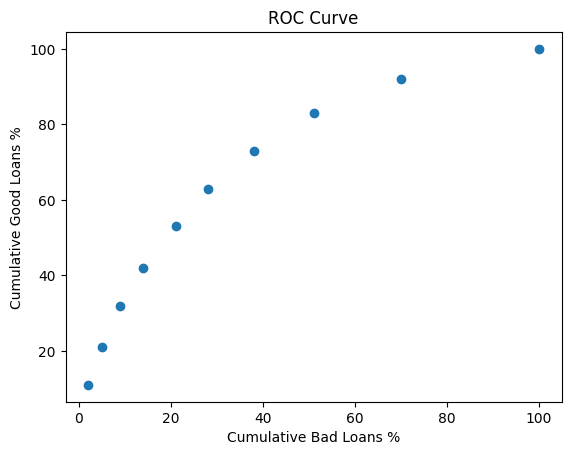

In [63]:
# Scatter plot
plt.scatter(pivot_table['CumSum Bad Loans %'], pivot_table['CumSum Good Loans %'])
plt.ylabel('Cumulative Good Loans %')
plt.xlabel('Cumulative Bad Loans %')
plt.title('ROC Curve')
plt.show()

## **Example**

In [64]:
probabilities_class_0 = predictions[:, 0]
print(probabilities_class_0)

threshold = 0.9
val_preds = (probabilities_class_0 < threshold).astype(int)
print(val_preds)

[0.84050986 0.97534145 0.91823973 ... 0.75431982 0.97506038 0.84769079]
[1 0 0 ... 1 0 1]


In [65]:
def calculate_balance(y_actual, y_prediction, amt_credit, interest_rate):
    # Create a copy of y_actual and y_prediction
    y_actual_copy = y_actual.copy()
    y_prediction_copy = y_prediction.copy()

    # Replace 0 with 1 and 1 with -1 in y_actual_copy and y_prediction_copy
    y_actual_copy = y_actual_copy.replace({0: 1, 1: -1})
    y_prediction_copy = y_prediction_copy.replace({0: 1, 1: -1})

    # Calculate the balance based on different conditions
    balance = np.where((y_actual == 0) & (y_prediction == 0), interest_rate * amt_credit,
              np.where((y_actual == 0) & (y_prediction == 1), -interest_rate * amt_credit,
              np.where((y_actual == 1) & (y_prediction == 0), -amt_credit * (1 + interest_rate), 0)))

    return balance

def calculate_total_balance(df, balance_column):
    # Calculate the sum of the balance column in the DataFrame
    total_balance = sum(df[balance_column])
    formatted_amount = f"Rp{total_balance:,.2f}"
    return formatted_amount

# Select relevant columns and reset the index
XX = df_original.loc[X_test.index, ['AMT_CREDIT']].reset_index()
yy_actual = y_test.reset_index()

# Convert val_preds numpy array to a DataFrame with a column name
yy_prediction = pd.DataFrame(val_preds, columns=['Prediction'])

# Merge yy_actual and yy_prediction based on the index
merged_df = pd.merge(yy_actual, yy_prediction, left_index=True, right_index=True)
merged_df = XX.merge(merged_df, on='index')

interest_rate = 0

# Calculate the different balance scenarios
merged_df['BALANCE'] = calculate_balance(
    merged_df['TARGET'], merged_df['Prediction'], merged_df['AMT_CREDIT'], interest_rate)
merged_df['IDEAL_BALANCE'] = calculate_balance(
    merged_df['TARGET'], merged_df['TARGET'], merged_df['AMT_CREDIT'], interest_rate)
merged_df['GIVE_ALL_LOAN'] = 0
merged_df['GIVE_ALL_LOAN_BALANCE'] = calculate_balance(
    merged_df['TARGET'], merged_df['GIVE_ALL_LOAN'], merged_df['AMT_CREDIT'], interest_rate)
merged_df['NOT_GIVE_ALL_LOAN'] = 1
merged_df['NOT_GIVE_ALL_LOAN_BALANCE'] = calculate_balance(
    merged_df['TARGET'], merged_df['NOT_GIVE_ALL_LOAN'], merged_df['AMT_CREDIT'], interest_rate)

# Calculate the total balances for different scenarios
ideal_formatted_amount = calculate_total_balance(merged_df, 'IDEAL_BALANCE')
curr_formatted_amount = calculate_total_balance(merged_df, 'BALANCE')
give_all_loan_formatted_amount = calculate_total_balance(merged_df, 'GIVE_ALL_LOAN_BALANCE')
not_give_all_loan_formatted_amount = calculate_total_balance(merged_df, 'NOT_GIVE_ALL_LOAN_BALANCE')

print('Ideal:', ideal_formatted_amount)
print('Current:', curr_formatted_amount)
print('GIVE_ALL_LOAN:', give_all_loan_formatted_amount)
print('NOT_GIVE_ALL_LOAN:', not_give_all_loan_formatted_amount)


Ideal: Rp0.00
Current: Rp-1,056,712,801.50
GIVE_ALL_LOAN: Rp-2,313,426,370.50
NOT_GIVE_ALL_LOAN: Rp0.00


In [66]:
loss_prevented = sum(merged_df['BALANCE']) - sum(merged_df['GIVE_ALL_LOAN_BALANCE'])
print(f"Loss prevented: Rp{loss_prevented:,.2f}")
prctg = round(loss_prevented / abs(sum(merged_df['GIVE_ALL_LOAN_BALANCE'])) * 100, 2)
print(f"That is {prctg}% from all losses that we might have.")

Loss prevented: Rp1,256,713,569.00
That is 54.32% from all losses that we might have.


## Attempting to submit predictions for `application_test`

In [67]:
pd.read_csv(file_dict['sample_submission']).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SK_ID_CURR  48744 non-null  int64  
 1   TARGET      48744 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 761.8 KB


In [68]:
sk_id = df_application_test['SK_ID_CURR'].values
sk_id

array([100001, 100005, 100013, ..., 456223, 456224, 456250])

In [69]:
# Re-group NAME_TYPE_SUITE
df_application_test['NAME_TYPE_SUITE'] = df_application_test['NAME_TYPE_SUITE'].replace({
    'Children': 'Family',
    'Family': 'Family',
    'Spouse, partner': 'Family',
    'Other_A': 'Other',
    'Other_B': 'Other',
    'Group of people': 'Other'
})

In [70]:
# Re-group NAME_FAMILY_STATUS
df_application_test['NAME_FAMILY_STATUS'] = df_application_test['NAME_FAMILY_STATUS'].replace({
    'Civil marriage': 'Married',
    'Married': 'Married',
    'Separated': 'Separated',
    'Widow': 'Separated',
    'Single / not married': 'Single'
})

In [71]:
# Re-group NAME_HOUSING_TYPE
df_application_test['NAME_HOUSING_TYPE'] = df_application_test['NAME_HOUSING_TYPE'].replace({
    'Rented apartment': 'Rented or Other Apartments',
    'Municipal apartment': 'Rented or Other Apartments',
    'Office apartment': 'Rented or Other Apartments',
    'Co-op apartment': 'Rented or Other Apartments'
})

In [72]:
# Re-group OCCUPATION_TYPE
df_application_test['OCCUPATION_TYPE'] = df_application_test['OCCUPATION_TYPE'].replace({
    'Laborers': 'Laborers',
    'Core staff': 'Professional',
    'Accountants': 'Professional',
    'Managers': 'Professional',
    'Drivers': 'Support Staff',
    'Sales staff': 'Support Staff',
    'Cleaning staff': 'Service Staff',
    'Cooking staff': 'Service Staff',
    'Private service staff': 'Service Staff',
    'Medicine staff': 'Service Staff',
    'Security staff': 'Service Staff',
    'High skill tech staff': 'Professional',
    'Waiters/barmen staff': 'Support Staff',
    'Low-skill Laborers': 'Laborers',
    'Realty agents': 'Professional',
    'Secretaries': 'Support Staff',
    'IT staff': 'Administrative',
    'HR staff': 'Administrative',
    'None': 'Other'
})

In [73]:
# Define the regex patterns for grouping
patterns = {
    r'Business Entity Type [1-3]': 'Business Entity',
    r'School|Kindergarten|University': 'Education',
    r'Government|Security Ministries|Police|Military': 'Government/Security',
    r'Electricity': 'Utilities',
    r'Medicine': 'Healthcare',
    r'Construction|Housing': 'Construction/Real Estate',
    r'Trade: type [1-7]': 'Trade',
    r'Industry: type [1-9]|Industry: type 1[01]|Industry: type 12|Industry: type 13': 'Industry',
    r'Transport: type [1-4]': 'Transport',
    r'Emergency': 'Emergency Services',
    r'Services': 'Services',
    r'Mobile|Telecom': 'Telecommunications',
    r'Bank|Insurance': 'Financial Services',
    r'Postal': 'Postal Services',
    r'Culture|Hotel|Restaurant|Cleaning|Advertising|Legal Services|Realtor': 'Services',
    r'None': 'Other'
}

# Function to perform regex grouping
def regex_grouping(value):
    for pattern, category in patterns.items():
        if re.search(pattern, value):
            return category
    return value

# Apply the regex grouping to the 'ORGANIZATION_TYPE' column
df_application_test['ORGANIZATION_TYPE'] = df_application_test['ORGANIZATION_TYPE'].apply(regex_grouping)

In [74]:
# Encode features using appropriate methods
binary_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder(sparse=False)

df_application_test['NAME_CONTRACT_TYPE_Revolving_loans'] = binary_encoder.fit_transform(df_application_test['NAME_CONTRACT_TYPE'])
df_application_test['CODE_GENDER_Male'] = binary_encoder.fit_transform(df_application_test['CODE_GENDER'])
df_application_test['FLAG_OWN_CAR'] = binary_encoder.fit_transform(df_application_test['FLAG_OWN_CAR'])
df_application_test['FLAG_OWN_REALTY'] = binary_encoder.fit_transform(df_application_test['FLAG_OWN_REALTY'])

# Perform one-hot encoding
categorical_features = [
    'NAME_TYPE_SUITE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
    'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE',
    'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE']

encoded_features = pd.get_dummies(df_application_test[categorical_features])

# Concatenate the encoded features back to the original dataframe
df_application_test_encoded = pd.concat([df_application_test, encoded_features], axis=1)

# Identify object columns
object_columns = df_application_test_encoded.select_dtypes(include=['object']).columns

# Drop the object columns
df_application_test_encoded = df_application_test_encoded.drop(object_columns, axis=1)

In [75]:
columns_to_drop = [
    'FLAG_MOBIL', 'CNT_FAM_MEMBERS', 'AMT_GOODS_PRICE', 'NAME_INCOME_TYPE_Pensioner', 
    'REGION_RATING_CLIENT_W_CITY', 'LIVE_REGION_NOT_WORK_REGION', 'LIVE_CITY_NOT_WORK_CITY', 
    'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'EXT_SOURCE_MEDIAN', 
    'NAME_TYPE_SUITE_Unaccompanied', 'OCCUPATION_TYPE_Other', 
    'NAME_EDUCATION_TYPE_Secondary / secondary special'
]

df_application_test_encoded.drop(columns_to_drop, axis=1, inplace=True)

In [76]:
days_columns = ['DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE']
df_application_test_encoded[days_columns] = df_application_test_encoded[days_columns].apply(abs)

In [77]:
# Converting days to years
df_application_test_encoded['AGE'] = df_application_test_encoded['DAYS_BIRTH'] / 365
df_application_test_encoded['YEARS_EMPLOYED'] = df_application_test_encoded['DAYS_EMPLOYED'] / 365
df_application_test_encoded['YEARS_REGISTRATION'] = df_application_test_encoded['DAYS_REGISTRATION'] / 365
df_application_test_encoded['YEARS_ID_PUBLISH'] = df_application_test_encoded['DAYS_ID_PUBLISH'] / 365
df_application_test_encoded['YEARS_LAST_PHONE_CHANGE'] = df_application_test_encoded['DAYS_LAST_PHONE_CHANGE'] / 365

In [78]:
# Calculate the age at which a client started current employment
df_application_test_encoded['AGE_EMPLOYED'] = df_application_test_encoded['AGE'] - df_application_test_encoded['YEARS_EMPLOYED']
# Calculate the age at which a client changed their registration
df_application_test_encoded['AGE_REGISTRATION'] = df_application_test_encoded['AGE'] - df_application_test_encoded['YEARS_REGISTRATION']
# Calculate the age at which a client changed their identity document
df_application_test_encoded['AGE_ID_PUBLISH'] = df_application_test_encoded['AGE'] - df_application_test_encoded['YEARS_ID_PUBLISH']
# Calculate the age at which a client changed their phone
df_application_test_encoded['AGE_LAST_PHONE_CHANGE'] = df_application_test_encoded['AGE'] - df_application_test_encoded['YEARS_LAST_PHONE_CHANGE']

In [79]:
columns_to_drop = [
    'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE',
    'AGE_EMPLOYED', 'AGE_ID_PUBLISH', 'AGE_LAST_PHONE_CHANGE']

df_application_test_encoded.drop(columns_to_drop, axis=1, inplace=True)

In [80]:
# Get all feature columns except the target column
df_application_test_encoded['NAME_INCOME_TYPE_Maternity leave'] = 0

# Store the column order of the training dataset
train_cols_order = df_original.columns.drop('TARGET')

# Select and reorder the columns in the test dataset
df_application_test_encoded = df_application_test_encoded[train_cols_order]

# Scale the feature columns using the previously fitted scaler
df_application_test_encoded[feature_cols] = scaler.transform(df_application_test_encoded[feature_cols])

In [81]:
feature_Kbest = set(selected_features)
feature_RF = set(sorted_feature_names[:15])
end_features = list(feature_Kbest.union(feature_RF))

df_test_final = df_application_test_encoded[['SK_ID_CURR'] + end_features]

In [82]:
test_prob = model.predict_proba(df_test_final.drop(['SK_ID_CURR'], axis=1))[:, 1]
test_prob

array([0.04407309, 0.12446291, 0.0300665 , ..., 0.05657421, 0.06199716,
       0.11195755])

In [83]:
end = pd.DataFrame({
    'SK_ID_CURR': sk_id,
    'TARGET': test_prob})
end.head()

,SK_ID_CURR,TARGET
0,100001,0.044073
1,100005,0.124463
2,100013,0.030066
3,100028,0.063291
4,100038,0.170900


In [84]:
end.to_csv(f'{folder_path}/first_submission.csv', index=False)

In [87]:
# Add 0.4 to each element and limit the maximum value to 1
modified_prob = [min(prob + 0.4, 1) for prob in test_prob]
end2 = pd.DataFrame({
    'SK_ID_CURR': sk_id,
    'TARGET': modified_prob})

end2.to_csv(f'{folder_path}/second_submission.csv', index=False)

In [86]:
# Add 0.47 to each element and limit the maximum value to 1
modified_prob2 = [max(prob + 0.47, 1) for prob in test_prob]
end3 = pd.DataFrame({
    'SK_ID_CURR': sk_id,
    'TARGET': modified_prob2})

end3.to_csv(f'{folder_path}/third_submission.csv', index=False)

## **END**

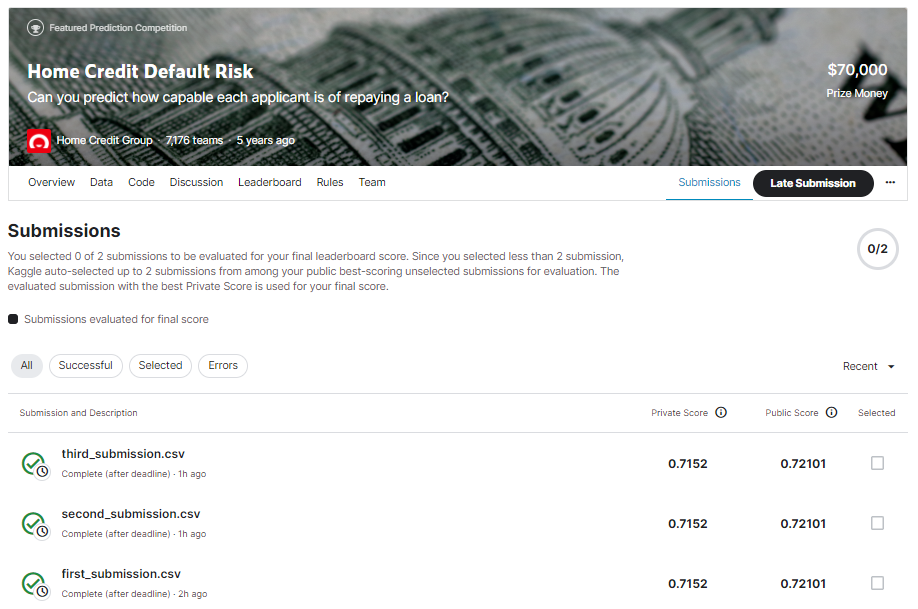